In [1]:
# Importing relevant modules
import numpy
import pandas as pd
import matplotlib
%matplotlib inline
from tqdm import tqdm_notebook as tqdm
import sklearn
import sklearn.model_selection
import sklearn.neural_network
import sklearn.ensemble
import sklearn.svm
import sklearn.preprocessing
import sklearn.metrics
import scipy.stats


# Ignoring warnings
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Load Dataset:
data_url = 'https://raw.githubusercontent.com/Moataz-AbdElKhalek/Concrete_Compressive_Strength_Prediction/main/dataset/Concrete_Dataset_Classification.csv'
dataset = pd.read_csv(data_url)

print(dataset.head(4))

# Descriptive statistics
print("\nDataset has {} rows and {} columns".format(dataset.shape[0],dataset.shape[1]))

print()
y = dataset['y']
print(y.head(4))
print(y.shape)
print()

X = dataset.drop(['y'], axis=1)
print(X.head(4))
print(X.shape)

      X1     X2   X3     X4   X5      X6     X7     X8    y
0  540.0    0.0  0.0  162.0  2.5  1040.0  676.0   28.0  1.0
1  540.0    0.0  0.0  162.0  2.5  1055.0  676.0   28.0  1.0
2  332.5  142.5  0.0  228.0  0.0   932.0  594.0  270.0  1.0
3  332.5  142.5  0.0  228.0  0.0   932.0  594.0  365.0  1.0

Dataset has 1030 rows and 9 columns

0    1.0
1    1.0
2    1.0
3    1.0
Name: y, dtype: float64
(1030,)

      X1     X2   X3     X4   X5      X6     X7     X8
0  540.0    0.0  0.0  162.0  2.5  1040.0  676.0   28.0
1  540.0    0.0  0.0  162.0  2.5  1055.0  676.0   28.0
2  332.5  142.5  0.0  228.0  0.0   932.0  594.0  270.0
3  332.5  142.5  0.0  228.0  0.0   932.0  594.0  365.0
(1030, 8)


In [3]:
# Applying statistical Analysis on the data:
dataset.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,y
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.167864,73.895825,54.188350,181.567282,6.204660,972.918932,773.580485,45.662136,-0.048544
std,104.506364,86.279342,63.997004,21.354219,5.973841,77.753954,80.175980,63.169912,0.999306
min,102.000000,0.000000,0.000000,121.800000,0.000000,801.000000,594.000000,1.000000,-1.000000
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,-1.000000
50%,272.900000,22.000000,0.000000,185.000000,6.400000,968.000000,779.500000,28.000000,-1.000000
75%,350.000000,142.950000,118.300000,192.000000,10.200000,1029.400000,824.000000,56.000000,1.000000
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,1.000000


# **Data Preprocessing**

In [4]:
# Using Scikit-learn MaxMinScaler: 
scaler = sklearn.preprocessing.MinMaxScaler(feature_range=(-1, 1))

# extract attributes and scale data to have Min = 0 and Max = 1 :
cols = X.columns
print('Data Attributes:\n', cols)
print('\nBefore Data Scaling:\n', X.head(4))
sc_X = scaler.fit_transform(X) # Fit scaler to data, then transform data to specified feature_range(0,1)

# Turn the scaling results back into a dataframe :
sc_X_df = pd.DataFrame(sc_X, columns = cols)
X = sc_X_df
print('\nAfter Data Scaling:\n', X.head(4))

# Applying statistical Analysis on the data:
X.describe()

Data Attributes:
 Index(['X1', 'X2', 'X3', 'X4', 'X5', 'X6', 'X7', 'X8'], dtype='object')

Before Data Scaling:
       X1     X2   X3     X4   X5      X6     X7     X8
0  540.0    0.0  0.0  162.0  2.5  1040.0  676.0   28.0
1  540.0    0.0  0.0  162.0  2.5  1055.0  676.0   28.0
2  332.5  142.5  0.0  228.0  0.0   932.0  594.0  270.0
3  332.5  142.5  0.0  228.0  0.0   932.0  594.0  365.0

After Data Scaling:
          X1        X2   X3        X4       X5        X6       X7        X8
0  1.000000 -1.000000 -1.0 -0.357827 -0.84472  0.389535 -0.58856 -0.851648
1  1.000000 -1.000000 -1.0 -0.357827 -0.84472  0.476744 -0.58856 -0.851648
2  0.052511 -0.207012 -1.0  0.696486 -1.00000 -0.238372 -1.00000  0.478022
3  0.052511 -0.207012 -1.0  0.696486 -1.00000 -0.238372 -1.00000  1.000000


,X1,X2,X3,X4,X5,X6,X7,X8
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,-0.181882,-0.588782,-0.458387,-0.045251,-0.614617,-0.000471,-0.098944,-0.754604
std,0.477198,0.480130,0.639650,0.341122,0.371046,0.452058,0.402288,0.347087
min,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,-0.587329,-1.000000,-1.000000,-0.311502,-1.000000,-0.238372,-0.312845,-0.967033
50%,-0.219635,-0.877574,-1.000000,0.009585,-0.602484,-0.029070,-0.069242,-0.851648
75%,0.132420,-0.204508,0.182409,0.121406,-0.366460,0.327907,0.154039,-0.697802
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# **Random Forest Model Optimization**
# Using 10-fold Cross-Validation

In [5]:
def RFC_CV(max_depth_range,min_impurity_range):
    
  # Preparing the Model:
  model = sklearn.ensemble.RandomForestClassifier(criterion='gini', random_state=1)

  # Determining Model Hyperparameters to be tested and optimized:
  paras = {'max_depth':max_depth_range, 'min_impurity_decrease':min_impurity_range}
  # min_impurity_decrease is used instead of min_impurity_split as min_impurity_split is deprecated in favor of min_impurity_decrease.
  # And the official scikit-learn manual advises to use min_impurity_decrease.

  # Preparing Cross-Validation to be used to fit the Model and the Hyperparameters:
  # Using 10-fold Cross-Validation:
  gridCV = sklearn.model_selection.GridSearchCV(model, paras, cv=10, scoring='accuracy', verbose=10, n_jobs= -1)
  gridCV.fit(X, y)

  best_max_depth = gridCV.best_params_['max_depth']
  best_min_impurity = gridCV.best_params_['min_impurity_decrease']
  best_score = gridCV.best_score_
  results = gridCV.cv_results_

  return best_max_depth, best_min_impurity, best_score, results

In [6]:
best_max_depth, best_min_impurity, best_score, cv_results = RFC_CV([1, 5, 7, 12, 100],[0, 1e-10, 1e-5, 0.01, 0.1])

Fitting 10 folds for each of 25 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.0s
[Parallel(n_jobs=-1)]: Done  57 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  81 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done  94 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done 109 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 124 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed:   

In [7]:
print('best_max_depth =',best_max_depth)
print('best_min_impurity =',best_min_impurity)
print('Cross-Validation Mean Best Score for the Model =',best_score)
print('\nCross-Validation Mean Test Scores\n', cv_results['mean_test_score'])

for i in range(10):
  print('\nSplit_'+str(i+1)+' Scores\n',cv_results['split'+str(i)+'_test_score'])
  print('best_score (Split_'+str(i+1)+') =', max(cv_results['split'+str(i)+'_test_score']))

best_max_depth = 7
best_min_impurity = 1e-10
Cross-Validation Mean Best Score for the Model = 0.770873786407767

Cross-Validation Mean Test Scores
 [0.6592233  0.6592233  0.6592233  0.6592233  0.55436893 0.74854369
 0.74854369 0.74854369 0.73106796 0.55436893 0.76990291 0.77087379
 0.76893204 0.72621359 0.55436893 0.76990291 0.76504854 0.76601942
 0.72718447 0.55436893 0.76213592 0.76504854 0.76699029 0.72718447
 0.55436893]

Split_1 Scores
 [0.55339806 0.55339806 0.55339806 0.55339806 0.52427184 0.74757282
 0.74757282 0.74757282 0.67961165 0.52427184 0.73786408 0.73786408
 0.73786408 0.67961165 0.52427184 0.72815534 0.72815534 0.72815534
 0.67961165 0.52427184 0.72815534 0.72815534 0.72815534 0.67961165
 0.52427184]
best_score (Split_1) = 0.7475728155339806

Split_2 Scores
 [0.7961165  0.7961165  0.7961165  0.7961165  0.48543689 0.67961165
 0.67961165 0.67961165 0.63106796 0.48543689 0.6407767  0.6407767
 0.6407767  0.60194175 0.48543689 0.66019417 0.66019417 0.66019417
 0.60194175 0.

# **Data Fixed Single Splitting**
(70% Training and 30% Testing)

In [8]:
# Dividing samples dataset into training and test datasets:
def dataset_divide(X, y):
  X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, train_size=0.70, random_state=1)
  return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = dataset_divide(X,y)
print(X_train.shape)
print(X_train.head(4))
print(y_train.shape)
print(X_test.shape)
print(X_test.head(4))
print(y_test.shape)

(721, 8)
           X1        X2        X3  ...        X6        X7        X8
185 -0.450228 -1.000000 -0.033483  ... -0.034302  0.386352 -0.928571
286 -0.637443 -1.000000  0.669165  ...  0.480233 -0.077772 -0.851648
600  0.082192 -1.000000 -1.000000  ... -0.029070 -0.061716 -0.928571
691 -0.497717 -0.213689 -1.000000  ...  0.002326 -0.217260 -0.989011

[4 rows x 8 columns]
(721,)
(309, 8)
           X1        X2        X3  ...        X6        X7        X8
339 -0.108676 -1.000000  0.174413  ...  0.289535 -0.199699 -0.989011
244 -0.378539 -1.000000 -0.059470  ... -0.134302  0.269443 -0.989011
882 -0.826484 -0.259878  0.029485  ... -0.331395 -0.202208 -0.851648
567 -0.536530 -0.244853 -1.000000  ...  0.600000 -0.170597 -0.967033

[4 rows x 8 columns]
(309,)


# **Random Forest Final Optimized Model**

In [9]:
# RF Classification Model:
def RF_Classification(X,y, optimum_max_depth=7, optimum_min_impurity=1e-10):
  model = sklearn.ensemble.RandomForestClassifier(criterion='gini', max_depth = optimum_max_depth, min_impurity_decrease = optimum_min_impurity, random_state=1)
  model.fit(X, y)

  return model

Score of Model Evaluation with Testing Data = 0.8511326860841424
rmse_test =  0.7716665443463455
pcc_test =  0.7021873952396918
scc_test =  0.7021873952396916


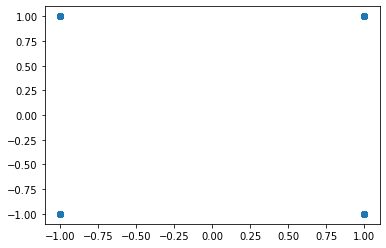

Score of Model Evaluation with Training Data = 0.9805825242718447
rmse_train =  0.2786932057166471
pcc_train =  0.9611069287996159
scc_train =  0.961106928799616


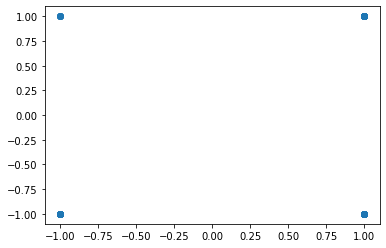

In [10]:
# RF Classification Model Training:
RF_Model = RF_Classification(X_train, y_train)

# RF Classification Model Evaluation on Testing Data:
current_score = RF_Model.score(X_test,y_test)
y_test_hat = RF_Model.predict(X_test) # testing output

print('Score of Model Evaluation with Testing Data =', current_score)
# RMSE
rmse_test = sklearn.metrics.mean_squared_error(y_test, y_test_hat, squared=False)
print('rmse_test = ',rmse_test)

# Pearson's correlation
pcc_test = scipy.stats.pearsonr(y_test, y_test_hat)[0]
print ('pcc_test = ', pcc_test)

#Spearman's correlation
scc_test = scipy.stats.spearmanr(y_test, y_test_hat)[0]
print ('scc_test = ', scc_test)

matplotlib.pyplot.scatter(y_test,y_test_hat)
matplotlib.pyplot.show()

# RF Classification Model Evaluation on Training Data:
current_score = RF_Model.score(X_train,y_train)
y_train_hat = RF_Model.predict(X_train) # testing output

print('Score of Model Evaluation with Training Data =', current_score)
# RMSE
rmse_train = sklearn.metrics.mean_squared_error(y_train, y_train_hat, squared=False)
print('rmse_train = ',rmse_train)
# Pearson's correlation
pcc_train = scipy.stats.pearsonr(y_train, y_train_hat)[0]
print ('pcc_train = ', pcc_train)

#Spearman's correlation
scc_train = scipy.stats.spearmanr(y_train, y_train_hat)[0]
print ('scc_train = ', scc_train)

matplotlib.pyplot.scatter(y_train,y_train_hat)
matplotlib.pyplot.show()